<a href="https://colab.research.google.com/github/levizwannah/drunk-detection-QCNN/blob/main/QCNNDrunkDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Preprocessing**  
Information on the Dataset
***********************************************************

                SOBER  -  DRUNK   DATA BASE

(Started September 2012    ----   Completed April 2013)

Electronics Laboratory - Physics Department
University of Patras  -  Greece

By Georgia Koukiou and Vassilis Anastassopoulos
gkoukiou@upatras.gr      vassilis@upatras.gr 

Every body can use this data base testing and publishing 
experimental results, provided that she/he will refer to 
relevant publications of the creators of this database. 

***********************************************************  
**The Dataset**  
It contains data for 41 persons.
For each person there are 16 different acquisitions
Each acquisition corresponds to each file of the data base
Each file contains 50 sequential frames of the same object 
acquired every 100msec, i.e. in 5 sec all 50 frames.  

The following MATLAB program is provided for reading each 
   separate file

***********************************************************
```
clc;
clear all;
close all;

c=zeros(128,160);
for i=1:50
    a(i).data=imread('filename.tif',i);
    xm(i).data=min(min(a(i).data)); 
    a(i).data=(a(i).data-xm(i).data);
    for j=1:128
        for k=1:160
            c(j,k)=c(j,k)+a(i).data(j,k);
        end
    end
end
```
***********************************************************

Infrared image acquisition

Time 20:50
Firstly, for each sober person, which is in calm condition,
an infrared sequence (1) is obtained from his Face (f), from 
his Eyes (e), from his Ear-profile (r), and his Hand (h).

> 21:00 - 22:00
After that four glasses of wine are drunk in one hour time.

> 22:20
A new sequence (2) of infrared images is acquired 
    (f), (e), (r), (h).

> 22:50
A new sequence (3) of infrared images is acquired 
    (f), (e), (r), (h).

> 23:20
A new sequence (4) of infrared images is acquired 
    (f), (e), (r), (h).

We had the people in groups of 4 or 5 or 6 persons. 
For two groups (10 people) we asked the police to carry 
out measurement with alcohol-meter. 
We have the correspondence of these measurements 
with the persons. 

***********************************************************

Naming the files
serialnumber_personfirstname_acquisitionsequence_imagecontent
_sex_age_weight__alcoholmeter

The two last measurements were obtained from few persons

***********************************************************

In [ ]:
!pip uninstall tensorflow
!pip uninstall tensorflow-io
!pip uninstall tensorflow-gpu
!pip install tensorflow-gpu
!pip install --no-deps tensorflow-io

In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile as zp
import PIL

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
imageDirectory = "/content/drive/MyDrive/isp2Data";
combinedData = tf.data.Dataset.list_files(imageDirectory + "/*.zip", shuffle=False)
combineDir = "/content/drive/MyDrive/isp2Data/combined"

In [ ]:
# extracting data
for f in combinedData.take(-1):
  with zp(f.numpy().decode("ASCII"), 'r') as zf:
    zf.extractall(combineDir)

In [4]:
import tensorflow_io as tfio

In [5]:
combinedImagePath = "/content/drive/MyDrive/isp2Data/combined"

In [6]:
allImages = dict();
allImages["Image"] = [];
allImages["Label"] = [];

for filename in os.listdir(combinedImagePath):

  info = filename.split("_");
  label = 'sober' if int(info[2]) == 1 else 'drunk'
  image = tf.io.read_file(combinedImagePath + "/" + filename)
  
  for i in range(50):
    
   data = tfio.experimental.image.decode_tiff(image, index = i)
   allImages['Image'].append(data)
   allImages['Label'].append(label)

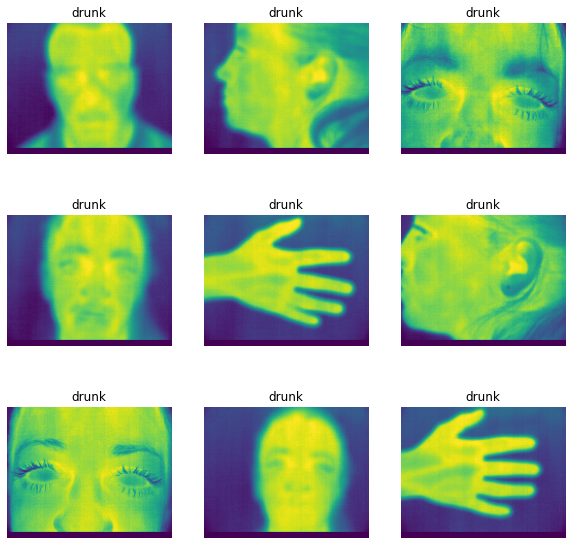

In [26]:
# displaying the first 10 images
counter = 1;
plt.figure(figsize=(10, 10))
for filename in os.listdir(combinedImagePath):
  info = filename.split("_");
  label = 'sober' if int(info[2]) == 1 else 'drunk'
  img = PIL.Image.open(combinedImagePath + "/" + filename)
  ax = plt.subplot(3, 3, counter)
  plt.imshow(img)
  plt.title(label)
  plt.axis("off")

  if(counter == 9): break

  counter += 1

In [7]:
mainDataset = tf.data.Dataset.from_tensor_slices((allImages['Image'], allImages['Label']))
allImages.clear();

In [ ]:
for Image, Label in mainDataset.take(1):
  print(Image.shape) # (128, 160, 4)
  print(Label.shape)

In [8]:
# path for saving the dataset
dsPath = "/content/drive/MyDrive/isp2Data/tfDataset";

In [ ]:
# rescaling the images
normLayer = tf.keras.layers.Rescaling(1./255)
normDataset = mainDataset.map(lambda x, y: (normLayer(x), y))
imageBatch, labelsBatch = next(iter(normDataset))
firstImage = imageBatch[0]
print(np.min(firstImage), np.max(firstImage))

In [10]:
# save the dataset
normDataset.save(dsPath)

In [13]:
del allImages

In [15]:
# get the dataset
mainDataset = tf.data.Dataset.load(dsPath)

In [ ]:
# start building the model
classCount = 2

